In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Introduction

Learning the value of a single stimulus is all good and fine, but in real-world environments, there are often multiple co-occurring stimuli that could be used as the basis for forming predictions. How do we learn about value in a multi-stimulus environment?

Based on [Bob Wilson's](http://u.arizona.edu/~bob/web_NSCS344/index.html) computational modeling class.

## 1.1 Maintaining separate prediction errors

Building off our simple temporal difference model from last time, we might expect that there's a straightforward solution to learning about multi-stimulus environments: maintain separate value estimates for each stimulus, as well as separate prediction errors.

The equation we used last time was:

$ V_{t} = V_{t-1} + \alpha (r_{t} - V_{t-1}) $

where $\alpha$ is a fixed learning rate.

So to model value-learning for two stimuli, we could say that:

$ V_{t}^{A} = V_{t-1}^{A} + \alpha (r_{t} - V_{t-1}^{A}) $

and

$ V_{t}^{B} = V_{t-1}^{B} + \alpha (r_{t} - V_{t-1}^{B}) $

unless the stimulus is absent on a given trial, in which case it retains its value without modification.

The code implementation is as follows:

In [2]:
def learn_separated_pe(alpha, trials, reward, a_present, b_present):
    value_a = np.empty(len(trials))
    value_b = np.empty(len(trials))

    for this_trial in trials:
        this_reward = reward[this_trial]
        this_a_present = a_present[this_trial]
        this_b_present = b_present[this_trial]

        if this_trial == 0:
            value_a[this_trial] = alpha * this_reward * this_a_present
            value_b[this_trial] = alpha * this_reward * this_b_present
        else:
            last_reward = reward[this_trial - 1]
            last_a_value = value_a[this_trial - 1]
            last_b_value = value_b[this_trial - 1]

            value_a[this_trial] = last_a_value + alpha * ((this_reward - last_a_value) * this_a_present)
            value_b[this_trial] = last_b_value + alpha * ((this_reward - last_b_value) * this_b_present)
    
    return pd.DataFrame(
        {
            'value_a_sep_pe': value_a,
            'value_b_sep_pe': value_b
        }
    )

## 1.2 Rescorla-Wagner

Historically, the key innovation of **`Rescorla-Wagner`** is that learning is driven by surprise. To put it differently, learning happens when your expectations are violated, or when there is an error in your predictions. This is not a new idea for us (remember that our baseline model uses *two* PEs to perform value-learning). In fact, Kamin had proposed something similar in the late 1960s ([the surprise hypothesis](http://www.scholarpedia.org/article/Kamin_blocking#Kamin.E2.80.99s_surprise_hypothesis_of_learning)).

But, there's a second innovation that has caused Rescorla-Wagner to have staying power in psychology. If all we had was Kamin's surprise hypothesis, we don't have an exact mechanism for determining *which* stimuli are eligible for learning through surprise. Indeed, in our baseline model, we assumed that people maintain separate prediction errors for all stimuli that appear in a given learning event. Rescorla-Wagner proposed something different: there are not two *separate* PEs being used to drive learning, but rather a single, *summated* PE. In other words, the surprise signal is built from the discrepancy between the actual reward received and the reward-predictive value of *all* the stimuli that are present on a given learning trial. The value of a compound stimulus (i.e., all of the stimuli in a multi-stimulus environment) is literally just the sum of its parts. So given this single summated value, we're simply computing a single prediction error for the entire compound stimulus. But then that single prediction error drives value learning for every component of the compound stimulus.

We can write out this idea as an equation:

The prediction error $ \delta = r_{t} - \sum_{s} V_{t-1}^{s} $

where $V^{s}$ refers to the value estimate of every "component" stimulus that contributes to the "compound" stimulus. Which means that our value-learning equations look like this:

$ V_{t}^{A} = V_{t-1}^{A} + \alpha \delta $

$ V_{t}^{B} = V_{t-1}^{B} + \alpha \delta $

The code implementation is as follows:

In [3]:
def learn_summated_pe(alpha, trials, reward, a_present, b_present):
    value_a = np.empty(len(trials))
    value_b = np.empty(len(trials))

    for this_trial in trials:
        this_reward = reward[this_trial]
        this_a_present = a_present[this_trial]
        this_b_present = b_present[this_trial]

        if this_trial == 0:
            delta = this_reward
            value_a[this_trial] = alpha * delta * this_a_present
            value_b[this_trial] = alpha * delta * this_b_present
        else:
            last_reward = reward[this_trial - 1]
            last_a_value = value_a[this_trial - 1]
            last_b_value = value_b[this_trial - 1]
            delta = this_reward - (last_a_value * this_a_present) - (last_b_value * this_b_present)
            value_a[this_trial] = last_a_value + alpha * delta * this_a_present
            value_b[this_trial] = last_b_value + alpha * delta * this_b_present
    
    return pd.DataFrame(
        {
            'value_a_sum_pe': value_a,
            'value_b_sum_pe': value_b
        }
    )

## 1.3 Simulating model predictions

So, which of these models is more true to how biological organisms actually learn? To answer this, we'll try simulating a few classic learning experiments, then compare each of the models against the empirically-observed phenomenon.

# 2.0 Overshadowing

## 2.1 Empirical phenomenon

In the **`training phase`**, a pigeon sees a bell and a light at the same time, then is given a food reward:  
$ \text{training phase: } A,B \rightarrow R $

Then, in the **`test phase`**, the pigeon is presented with the bell and light separately. We measure how much it expects reward (based on how much it pecks at the food tray):  
$ \text{test phase: } A \text{ alone, } B \text{ alone} $

The empirical pattern of results observed is:  
$ \text{test phase: } A \text{ alone (weak response), } B \text{ alone (weak response)} $

Let's build a function for simulating this experiment, then run it through both learning models.

In [4]:
# Function for simulating experiment
def sim_overshadowing(n_trials = 100):
    return pd.DataFrame(
        {
            'trial': np.arange(n_trials),
            'reward': np.ones(n_trials),
            'a_present': np.ones(n_trials),
            'b_present': np.ones(n_trials)
        }
    )

In [5]:
n_trials = 100

# Simulate experiment
sampled_overshadowing = sim_overshadowing(n_trials)

## 2.2 Model comparison

Let's now simulate two agents using the two different learning mechanisms, then compare their learning curves with the empirical phenomena.

In [6]:
learned_overshadowing_sep_pe = learn_separated_pe(
    0.2,
    sampled_overshadowing.trial,
    sampled_overshadowing.reward,
    sampled_overshadowing.a_present,
    sampled_overshadowing.b_present
    )

learned_overshadowing_sum_pe = learn_summated_pe(
    0.2,
    sampled_overshadowing.trial,
    sampled_overshadowing.reward,
    sampled_overshadowing.a_present,
    sampled_overshadowing.b_present
    )

results_overshadowing = pd.concat(
    [sampled_overshadowing, learned_overshadowing_sep_pe, learned_overshadowing_sum_pe],
    axis=1
    )

The color-coding in this next plot is atrocious, but it communicates three important findings:

1. If an agent is trying to optimize for "accurately" learning the reward-predictive value of the stimuli, maintaining separate PEs affords this: the green and orange lines converge to the blue line.
2. On the other hand, if an agent is maintaining only a single PE (where the reward prediction is a simple summation of the previously-learned value of all stimuli in the environment), this causes the agent to learn a "discounted" value for the stimuli: the purple and red lines asymptote at *half* of the true reward.
3. The empirical phenomenon of overshadowing is better-described by the summated PE model (Rescorla-Wagner).

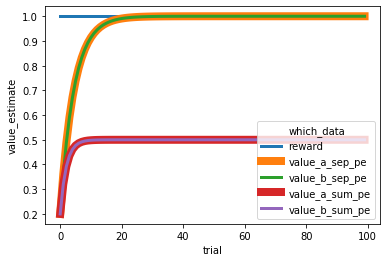

In [7]:
sns.lineplot(
    x = 'trial',
    y = 'value_estimate',
    hue = 'which_data',
    size = 'which_data',
    sizes = [3, 8, 3, 8, 3],
    data = pd.melt(
        frame = results_overshadowing,
        id_vars = ['trial', 'a_present', 'b_present'],
        var_name = 'which_data',
        value_name = 'value_estimate'
        )
)

# 3.0 Blocking

## 3.1 Empirical phenomenon

In this experiment, we have a pigeon undergo a learning phase in which a bell predicts food:  
$ \text{training phase 1: } A \rightarrow R $

Then, the pigeon undergoes a second learning phase in which a bell and light both predict food:  
$ \text{training phase 2: } A, B \rightarrow R $

The empirical pattern of results observed is:  
$ \text{test phase: } A \text{ alone (strong response), } B \text{ alone (no response)} $

In [8]:
# Function for simulating experiment
def sim_blocking(n_trials=100, n_training_1=None, n_training_2=None):
    # There could in principle be asymmetries in the number of training trials
    # If only a single number of trials is specified, assume half/half split
    if n_training_1 is None:
        n_training_1 = round(n_trials/2)
        n_training_2 = n_trials - n_training_1
    
    return pd.DataFrame(
        {
            'trial': np.arange(n_training_1 + n_training_2),
            'reward': np.ones(n_training_1 + n_training_2),
            'a_present': np.ones(n_training_1 + n_training_2),
            'b_present': np.concatenate([np.zeros(n_training_1), np.ones(n_training_2)])
        }
    )

In [9]:
# Simulate experiment
sampled_blocking = sim_blocking(n_trials)

## 3.2 Model comparison

In [10]:
learned_blocking_sep_pe = learn_separated_pe(
    0.2,
    sampled_blocking.trial,
    sampled_blocking.reward,
    sampled_blocking.a_present,
    sampled_blocking.b_present
    )

learned_blocking_sum_pe = learn_summated_pe(
    0.2,
    sampled_blocking.trial,
    sampled_blocking.reward,
    sampled_blocking.a_present,
    sampled_blocking.b_present
    )

results_blocking = pd.concat(
    [sampled_blocking, learned_blocking_sep_pe, learned_blocking_sum_pe],
    axis=1
    )

This next plot is somehow even more horrible, but we are able to glean a few important things:

1. In the model that maintains separate PEs (orange and green lines), we see that the "learning curve" looks identical for both. Since B wasn't presented until the second half of the experiment, it's sensible that it's displaced along the x-axis. The learned value of A has no effect on the agent learning the value of B (and vice versa).
2. In the model that summates a single PE (red and purple lines), we see a very different pattern. The agent has no problem learning A, but we see that having learned the value of A "blocks" learning about B. Why is this? In the second half of the experiment, there is no surprise signal, as the agent can fully use A to predict the reward. Since there's no surprise, there's no need for further learning. Since there's no need for further learning, the agent never learns the value of B.
3. The empirical phenomenon of blocking is better-described by the summated PE model (Rescorla-Wagner).

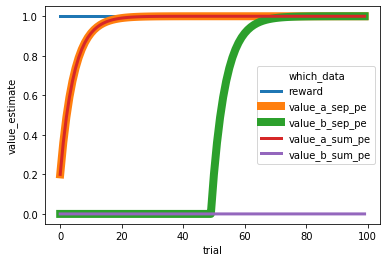

In [11]:
sns.lineplot(
    x = 'trial',
    y = 'value_estimate',
    hue = 'which_data',
    size = 'which_data',
    sizes = [3, 8, 8, 3, 3],
    data = pd.melt(
        frame = results_blocking,
        id_vars = ['trial', 'a_present', 'b_present'],
        var_name = 'which_data',
        value_name = 'value_estimate'
        )
)

# 4.0 Inhibition

## 4.1 Empirical phenomenon

In this experiment, we have a pigeon undergo a learning phase in which a bell alone predicts food, but a bell and light together predicts no reward:  
$ \text{training phase: } A \rightarrow R \text{ or } A, B \rightarrow 0 $  

Despite the pigeon having never seen B by itself, nor paired with a punishment, the empirical pattern of results observed is:  
$ \text{test phase: } A \text{ alone (strong response), } B \text{ alone (negative response)} $

In [12]:
def sim_inhibition(n_trials):
    # [1 = A -> R] and [0 = A, B -> R]
    a_only = np.random.binomial(1, 0.5, n_trials)
    return pd.DataFrame(
        {
            'trial': np.arange(n_trials),
            'a_only_trial': a_only,
            'reward': np.where(a_only == 1, 1, 0),
            'a_present': np.ones(n_trials),
            'b_present': np.where(a_only == 1, 0, 1)
        }
    )

In [13]:
sampled_inhibition = sim_inhibition(n_trials)

## 4.2 Model comparison

In [14]:
learned_inhibition_sep_pe = learn_separated_pe(
    0.2,
    sampled_inhibition.trial,
    sampled_inhibition.reward,
    sampled_inhibition.a_present,
    sampled_inhibition.b_present
    )

learned_inhibition_sum_pe = learn_summated_pe(
    0.2,
    sampled_inhibition.trial,
    sampled_inhibition.reward,
    sampled_inhibition.a_present,
    sampled_inhibition.b_present
    )

results_inhibition = pd.concat(
    [sampled_inhibition, learned_inhibition_sep_pe, learned_inhibition_sum_pe],
    axis=1
    )

The plot below manages to be kind of cool in spite of itself. Here's what we can see:

1. In the model with separate prediction errors (orange and green), the value of A is about 0.5, reflecting that A is always shown and that 50% of trials result in reward. The value of B is 0, reflecting that the reward is always 0 when B is shown.
2. In the model with a single summated prediction error (red and purple), the value of A converges to 1, and the value of B converges to -1. This means that the agent treats A as being a deterministic predictor of reward. Since the A-B pairing results in no reward, it implies that B must have an equally punishing value as A.
3. Once again, the empirical phenomenon of inhibition is better-described by the summated PE model (Rescorla-Wagner).

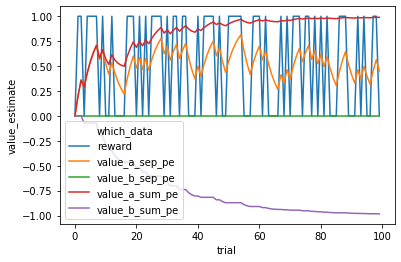

In [15]:
sns.lineplot(
    x = 'trial',
    y = 'value_estimate',
    hue = 'which_data',
    data = pd.melt(
        frame = results_inhibition,
        id_vars = ['trial', 'a_present', 'b_present', 'a_only_trial'],
        var_name = 'which_data',
        value_name = 'value_estimate'
        )
)